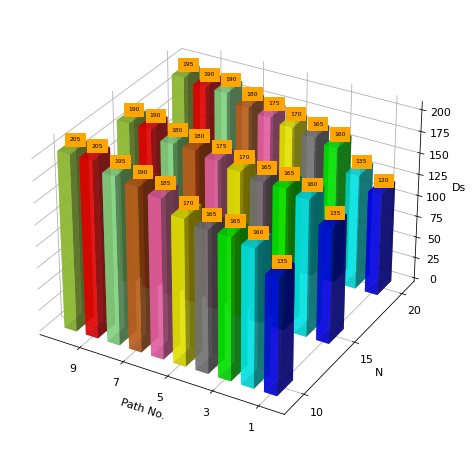

In [6]:
import numpy as np
import random
import math
import copy
from Draw_3D_chart import BarChart

class Solution(object):
    def __init__(self):
        self.path = []
        self.code = []
        self.fitness = float('inf')

class FA:

    def __init__(self, src, dst, N, Max, K_paths, y, a0, b0):
        self.switches = [i for i in range(1,51)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.population = [self.CreateSolution() for i in range(self.N)]
        self.y = y
        self.a0 = a0
        self.b0 = b0
        self.a = 0
        self.condidates = []
        self.best = []
        self.values = []
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('../../metric_data.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateSolution(self):
        newSolution = Solution()
        path=[]
        code = []
        while(len(path)==0):
            code.clear()
            path.clear()
            code = copy.deepcopy([random.uniform(-1,1) for i in range(len(self.switches))])
            path = copy.deepcopy(self.Decode(code))
        newSolution.code = copy.deepcopy(code)
        newSolution.path = copy.deepcopy(path)
        newSolution.fitness = self.Evaluate(newSolution.path)
        return newSolution
    
    def Decode(self,code):
        path = []
        path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                break
            switch_min = 1
            min = float('inf')
            for switch in neighbor_switches:
                if(code[switch-1] <= min):
                    min = code[switch-1]
                    switch_min = switch
            current_switch = switch_min
            path.append(current_switch)
        return path

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def Normalize(self,code):
        code_2 = copy.deepcopy(code)
        mn = min(code_2)
        mx = max(code_2)
        for j in range(len(self.switches)):
            code[j] = -1+2*(code_2[j]-mn)/(mx-mn)
        return code
    
    def Attract(self):
        for i in range(self.N):
            for j in range(self.N):
                newSolution = Solution()
                if(self.population[i].fitness > self.population[j].fitness):
                    r2 = 0
                    for j1 in range(len(self.switches)):
                        number = self.population[i].code[j1] - self.population[j].code[j1]
                        r2 += pow(number,2)
                    b = self.b0*math.exp(-self.y*r2)
                    for j2 in range(len(self.switches)):
                        newSolution.code.append(self.population[i].code[j2] + b*(self.population[j].code[j2] - self.population[i].code[j2]))
                    code_2 = [0 for i in range(len(self.switches))]
                    while(len(newSolution.path)==0):
                        for j2 in range(len(self.switches)):
                            e = np.random.rand()-1/2
                            code_2[j2] = newSolution.code[j2] + self.a*2*e
                        code_2 = self.Normalize(code_2)
                        newSolution.path = copy.deepcopy(self.Decode(code_2))
                    newSolution.code = copy.deepcopy(code_2)
                    newSolution.fitness = self.Evaluate(newSolution.path)
                    self.population[i] = copy.deepcopy(newSolution)
                    
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for member in condidate:
                if(tuple(member.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for solution in self.best:
                if(tuple(solution.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for x in range(len(self.best)):
            self.values.append(self.best[x].fitness)
        file1 = open('../../wires.txt','r')
        Lines = file1.readlines()
        count = 0
        for line in Lines:
            if(line.strip()[0] == "A" or line.strip()[0] == "G" or line.strip()[0] == "F" or line.strip()[0] == "N"):
                count += 1
        file1.close()
        f1 = open("../../wires.txt","a")
        if(count==3):
            f1.truncate(0)
        stt_0 = ",".join(["N="+str(self.N),"Max="+str(self.Max)]) + "\n"
        f1.write(stt_0)
        for i in range(len(self.best)):
            stt = ",".join(str(self.weight_map[self.best[i].path[x]][self.best[i].path[x+1]]) for x in range(len(self.best[i].path) - 1))
            stt= stt+"\n"
            f1.write(stt)
        f1.close()

    def Do(self):
        for i in range(self.Max):
            self.a = self.a0*pow(0.99,i)
            self.Attract()
            self.MemorizeCondidates()
        self.GetBest()
        
N = [10,15,20]
Max = 1000
K_paths = 10
y = 1
a0 = 1
b0 = 1
src = 1
dst = 50
alg_00 = FA(src,dst,N[0],Max,K_paths,y, a0, b0)
alg_00.Do()
alg_01 = FA(src,dst,N[1],Max,K_paths,y, a0, b0)
alg_01.Do()
alg_11 = FA(src,dst,N[2],Max,K_paths,y, a0, b0)
alg_11.Do()
pr = ["10","15","20"]
pr.append("N")
chart = BarChart(alg_00.values, alg_01.values, alg_11.values, "N_FA", pr)
chart.Do()
f=open("../../demo.txt","w")
f.truncate(0)
for i in range(len(alg_11.best)):
    stt = ",".join(str(x) for x in alg_11.best[i].path)
    stt= stt+","+str(alg_11.best[i].fitness)+"\n"
    f.write(stt)
f.close()